In [1]:
import torch
from datareader import *
from torch import nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)


def cross_entrophy(yhat, y, label_smooth=0.1):
    # yhat是二维向量，第一个维度是batch， y是单维度的labels
    # 有待进一步测试
    real_y = torch.zeros(yhat.shape, device=device)
    real_y += label_smooth/yhat.shape[1]   # 应该能广播吧
    real_y[range(len(yhat)), y] += 1 - label_smooth
    loss = -torch.mul(real_y, torch.log(yhat))
    #除以batchsize
    return loss.sum(1, keepdim=True) / len(y)

def accuracy(yhat, y):
    # 计算正确的***数量***
    if len(yhat.shape) > 1 and yhat.shape[1] > 1:
        yhat = yhat.argmax(axis=1)
    cmp = yhat.type(y.dtype) == y
    cmp = cmp.type(y.dtype)
    s = cmp.sum()
    return float(s)

def evaluate_accuracy(net, data_iter, lossfun):
    # 三个参数都是function
    with torch.no_grad():
        if isinstance(net, torch.nn.Module):
            net.eval()
        metric = [0.0, 0.0]
        total_loss = 0
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            yhat = net(X)
            metric[0] += accuracy(yhat, y)
            total_loss += float(lossfun(yhat, y).sum()) * y.shape[0]
            metric[1] += y.shape[0]
        # 正确率和平均损失
        return metric[0]/metric[1], total_loss/metric[1]



device:  cuda:0
device:  cuda:0


In [2]:
# 定义网络
class ReShape(nn.Module):
    def forward(self, X):
        return X.view(-1, 1, 28, 28)
LeNet = torch.nn.Sequential(
    ReShape(),
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(120, 84), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(84, 10))
#    nn.Softmax(dim=1))  # loss fun包含了softmax

'''
print(type(LeNet))
print(LeNet[3].weight.shape)
X = torch.rand(size=(5, 1, 28, 28), dtype=torch.float32)
for layer in LeNet:
    X = layer(X)
    print(f'{layer.__class__.__name__} : ouput shape: {X.shape}')
'''


print(LeNet)

Sequential(
  (0): ReShape()
  (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=400, out_features=120, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=120, out_features=84, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=84, out_features=10, bias=True)
)


In [3]:
# 载入数据
train_reader = MNISTReader(1)
test_reader = MNISTReader(2)


In [4]:
def train(net, train_reader, test_reader, num_epochs, lr, device):
    def init_weight(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    print(f'training on: {device}')
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss(label_smoothing=0.1)

    res = [] # 训练集梯度，训练集正确率，训练集总数
    for epoch in range(num_epochs):
        recorder = [0.0, 0.0, 0.0] # 训练集梯度，训练集正确率，训练集总数
        net.train()
        for X, y in train_reader.dataIter(batch_size):
            # timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            yhat = net(X)
            l = loss(yhat, y)
            l.backward()
            optimizer.step()
            recorder[0] += float(l * X.shape[0]) #说明lossfun里，梯度除以了bachsize
            recorder[1] += accuracy(yhat, y)
            recorder[2] += X.shape[0]
        # 正确率和平均损失
        test_accu , test_loss = evaluate_accuracy(net, test_reader.dataIter(batch_size), loss)
        print(f'epoch = {epoch+1}')
        print(f'\t训练集正确率：{recorder[1]/recorder[2]:.3f}，训练集平均loss {recorder[0]/recorder[2]:.3f}.', end=' ')
        print(f'测试集正确率：{test_accu:.3f}，测试集平均loss {test_loss:.3f}.')
        res.append((recorder[1]/recorder[2], recorder[0]/recorder[2], test_accu, test_loss))
    return res

# 训练超参数
lr = 0.1
num_epoch = 55
batch_size = 500

# 正式训练
data_l = train(LeNet,
      train_reader,
      test_reader,
      num_epoch,
      lr,
      device)

training on: cuda:0
epoch = 1
	训练集正确率：0.453，训练集平均loss 1.688. 测试集正确率：0.728，测试集平均loss 1.124.
epoch = 2
	训练集正确率：0.683，训练集平均loss 1.256. 测试集正确率：0.778，测试集平均loss 1.013.
epoch = 3
	训练集正确率：0.739，训练集平均loss 1.161. 测试集正确率：0.803，测试集平均loss 0.958.
epoch = 4
	训练集正确率：0.766，训练集平均loss 1.109. 测试集正确率：0.818，测试集平均loss 0.926.
epoch = 5
	训练集正确率：0.787，训练集平均loss 1.074. 测试集正确率：0.830，测试集平均loss 0.904.
epoch = 6
	训练集正确率：0.799，训练集平均loss 1.048. 测试集正确率：0.832，测试集平均loss 0.894.
epoch = 7
	训练集正确率：0.810，训练集平均loss 1.024. 测试集正确率：0.839，测试集平均loss 0.877.
epoch = 8
	训练集正确率：0.818，训练集平均loss 1.010. 测试集正确率：0.850，测试集平均loss 0.858.
epoch = 9
	训练集正确率：0.826，训练集平均loss 0.993. 测试集正确率：0.849，测试集平均loss 0.851.
epoch = 10
	训练集正确率：0.832，训练集平均loss 0.977. 测试集正确率：0.856，测试集平均loss 0.836.
epoch = 11
	训练集正确率：0.838，训练集平均loss 0.965. 测试集正确率：0.859，测试集平均loss 0.831.
epoch = 12
	训练集正确率：0.842，训练集平均loss 0.956. 测试集正确率：0.862，测试集平均loss 0.820.
epoch = 13
	训练集正确率：0.845，训练集平均loss 0.947. 测试集正确率：0.867，测试集平均loss 0.813.
epoch = 14
	训练集正确率：0.850，训练集平均loss 0.936. 测试集正确率：0.86

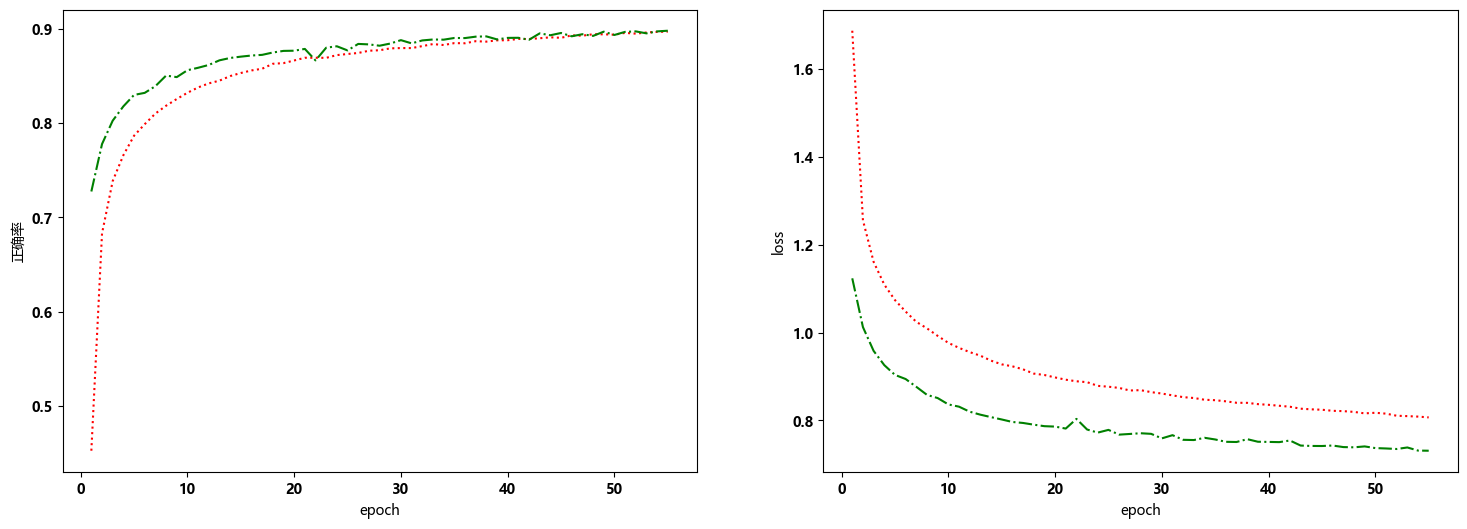

In [5]:
#绘图
#print(data_l)
import matplotlib.pyplot as plt

epoch_l = [i for i in range(1, num_epoch+1)]
y1 = [x[0] for x in data_l]
y2 = [x[2] for x in data_l]

y3 = [x[1] for x in data_l]
y4 = [float(x[3]) for x in data_l]

plt.figure(figsize=(18, 6), dpi=100)
plt.rc("font", family='MicroSoft YaHei', weight="bold")

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('正确率')
plt.plot(epoch_l, y1, color='red', linestyle=':', label='train set')
plt.plot(epoch_l, y2, color='green', linestyle='-.', label='test set')

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epoch_l, y3, color='red', linestyle=':', label='train set')
plt.plot(epoch_l, y4, color='green', linestyle='-.', label='test set')

plt.show()



In [6]:
# 统计分标签的正确率
if isinstance(LeNet, torch.nn.Module):
    LeNet.eval()
metric = [[0 for i in range(10)] for i in range(10)]  # 行表示正确的标签，列表示错误的标签
false_label = []
for X, y in test_reader.dataIter(1):
    yhat = LeNet(X)
    yhat = yhat.argmax(axis=1)
    metric[int(y)][int(yhat)] += 1
# 正确率和平均损失
for i in range(10):
    print(f'数字{i}的正确率{round(metric[i][i]/sum(metric[i]) * 100, 2)}%', end='\t')
    metric[i][i] = 0
    j = metric[i].index(max(metric[i]))
    print(f'最大误报数字为{j}, 次数为{metric[i][j]}')
    #print(' '.join([f'数字{j}误报次数{metric[i][j]}; ' if (metric[i][j] > 0 and i != j) else '' for j in range(10)]))

数字0的正确率86.6%	最大误报数字为6, 次数为88
数字1的正确率97.3%	最大误报数字为3, 次数为19
数字2的正确率82.6%	最大误报数字为4, 次数为80
数字3的正确率90.6%	最大误报数字为6, 次数为36
数字4的正确率85.5%	最大误报数字为6, 次数为65
数字5的正确率97.4%	最大误报数字为7, 次数为18
数字6的正确率67.9%	最大误报数字为0, 次数为129
数字7的正确率96.3%	最大误报数字为9, 次数为23
数字8的正确率97.9%	最大误报数字为4, 次数为5
数字9的正确率95.9%	最大误报数字为7, 次数为35


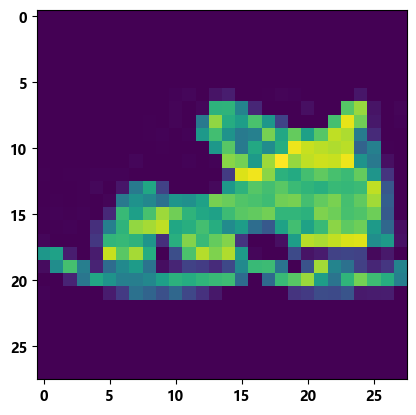

tensor([[-0.4414, -0.0992, -0.1789, -0.5684, -0.4363,  4.7140, -0.3041,  0.3730,
          0.0330, -0.1021]], device='cuda:0', grad_fn=<AddmmBackward0>)
模型预测数字为: 5，正确答案为: 5，

输入任意值继续:  


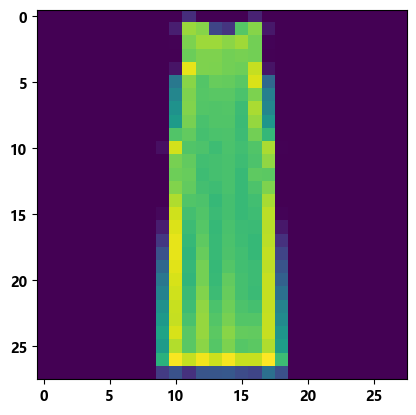

tensor([[ 0.3211,  0.5425, -0.6569,  4.3331, -0.1382, -0.6489,  0.0131, -0.9127,
         -0.5628, -0.4869]], device='cuda:0', grad_fn=<AddmmBackward0>)
模型预测数字为: 3，正确答案为: 3，

KeyboardInterrupt: Interrupted by user

In [7]:
# 展示效果
import matplotlib.pyplot as plt
from os import system
for imdata, label in test_reader.dataIter(1):
    system('cls')
    predict_re = LeNet(imdata)
    imdata = imdata *128 + 128
    imdata = imdata.reshape((28, 28))
    fig = plt.figure()
    plt.imshow(imdata.cpu())
    plt.show()
    print(predict_re)
    predict_num = torch.argmax(predict_re)
    print(f'模型预测数字为: {predict_num}，正确答案为: {int(label)}，', end='')
    input('输入任意值继续: ')